### Libraries and used functions

In [454]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import datetime as dt

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import requests
import plotly.express as px
import plotly.graph_objects as go

from IPython.display import HTML

from scipy.stats import f_oneway
from scipy.stats import pearsonr
from scipy.stats import mannwhitneyu

%matplotlib inline
# from pydantic_settings import BaseSettings
#from ydata_profiling import ProfileReport

import sys
import os
sys.path.append('../utils/')
#sys.path.append('..\\utils\\')

from functions import get_zone_info
from functions import haversine_distance as hsd
from functions import main_concurrent

In [455]:
def generate_custom_blue_scale(n_steps, dark_start=True):
    """
    Generate a custom blue color scale with n_steps.
    
    Args:
    - n_steps: Number of steps in the color scale.
    - dark_start: If True, start with a darker blue; otherwise, start lighter.
    
    Returns:
    - A list of color strings in RGB format.
    """
    cmap = plt.get_cmap('Blues')
    colors = [cmap(i) for i in np.linspace(0.3 if dark_start else 0, 1, n_steps)]  # Start from 0.3 to avoid too light colors
    # Convert colors to RGB format for Plotly
    plotly_colors = ["rgb({},{},{})".format(int(r*255), int(g*255), int(b*255)) for r, g, b, _ in colors]
    return plotly_colors

# # Example usage
n_steps = 24  # Define the number of steps you want in your color scale
custom_blue_scale = generate_custom_blue_scale(n_steps, dark_start=True)

# Green Scale
def generate_custom_green_scale(n_steps, dark_start=True):
    """
    Generate a custom green color scale with n_steps.
    
    Args:
    - n_steps: Number of steps in the color scale.
    - dark_start: If True, start with a darker green; otherwise, start lighter.
    
    Returns:
    - A list of color strings in RGB format.
    """
    cmap = plt.get_cmap('Greens')
    colors = [cmap(i) for i in np.linspace(0.3 if dark_start else 0, 1, n_steps)]  # Start from 0.3 to avoid too light colors
    # Convert colors to RGB format for Plotly
    plotly_colors = ["rgb({},{},{})".format(int(r*255), int(g*255), int(b*255)) for r, g, b, _ in colors]
    return plotly_colors

# Test the function
generate_custom_green_scale(5)



# # Using the custom color scale in Plotly
# fig = go.Figure(data=go.Contour(
#     z=[[10, 10.625, 12.5, 15.625, 20],
#        [5.625, 6.25, 8.125, 11.25, 15.625],
#        [2.5, 3.125, 5.0, 8.125, 12.5],
#        [0.625, 1.25, 3.125, 6.25, 10.625],
#        [0, 0.625, 2.5, 5.625, 10]],
#     colorscale=custom_blue_scale,
#     # other attributes here
# ))

# fig.show()

['rgb(184,226,177)',
 'rgb(125,200,125)',
 'rgb(58,164,88)',
 'rgb(13,120,53)',
 'rgb(0,68,27)']

## Data Cleaning and Preprocessing. Exploratory and Confirmatory Data Analysis

### 1. Data Cleaning and Processing.

In [456]:
# Initialize ShareNow and GreenMobility datasets
gm_original = pd.read_csv('../data/raw/GM_preparedData.csv')
sn_original = pd.read_excel('../data/raw/DriveNow/DTU - data til case_LTMZones1.xlsx')

#   ----------------------------------------------------------------------------
#   SHARENOW PART
#   ----------------------------------------------------------------------------

# Rename ShareNow columns
dict_sn_renamecols =    {'TurID':'TripID',
                        'BilID':'CarID',
                        'PersonID':'UserID',
                        'Latitude (Start)':'LatitudeStart',
                        'Longitude (Start)':'LongitudeStart',
                        'Latitude (Slut)': "LatitudeEnd", 
                        'Longitude (Slut)':'LongitudeEnd',
                        'Reservationstidspunkt': 'ReservationTime',
                        'Start tidspunkt': 'StartTime',
                        'Slut tidspunkt': 'EndTime',
                        'Alder': 'Age',
                        'Køn': 'Gender',
                        'Batteristatus (start)': 'BatteryStart',
                        'Batteristatus (slut)':'BatteryEnd',
                        'Km kørt': 'KmDriven'}

sn_processing = sn_original.rename(columns=dict_sn_renamecols)

# Check the data types of the dimensions
print(sn_processing.info())

# Convert BatteryStart and BatteryEnd to Integer type
sn_processing['BatteryStart'] = pd.to_numeric(sn_processing['BatteryStart'],errors='coerce')
sn_processing['BatteryEnd'] = pd.to_numeric(sn_processing['BatteryEnd'],errors='coerce')

# Convert location coordinates to floating type
coordinates = [
    'LatitudeEnd',
    'LatitudeStart',
    'LongitudeEnd',
    'LongitudeStart'
]

for col in coordinates:
    # sn_processing[col] = sn_processing[col].apply(lambda x: x.replace(',','.'))
    sn_processing[col] = pd.to_numeric(sn_processing[col],errors='coerce')

# Auxiliary columns
sn_processing['TripDurationHours'] = (sn_processing['EndTime'] - sn_processing['StartTime']).dt.total_seconds()/3600
sn_processing['TripDurationMinutes'] = sn_processing['TripDurationHours']*60  #   trip duration in min
sn_processing['AvgSpeed'] = sn_processing['KmDriven']/sn_processing['TripDurationHours'] #   avg speed
sn_processing['Month'] = sn_processing['StartTime'].dt.strftime("%B").astype('category')  #   month
sn_processing['Weekday'] = sn_processing['StartTime'].dt.day_name().astype('category')    #   day of the week
sn_processing['StartHour'] = sn_processing['StartTime'].dt.hour.astype('category')    #   hour of the day
sn_processing['Date'] = sn_processing['StartTime'].dt.date  #   date

sn_processing['HaversineDistance'] = hsd(sn_processing['LatitudeStart'], sn_processing['LongitudeStart'],sn_processing['LatitudeEnd'], sn_processing['LongitudeEnd'])

# Custom cut for age interval
dfbrackets = pd.DataFrame({
    'ranges': [range(18, 30), range(30, 40), range(40, 50), range(50, 60), range(60, 91)],
    'brackets': ['18-29', '30-39', '40-49', '50-59', '60-90']
}).explode('ranges')

dfbrackets['ranges'] = dfbrackets['ranges'].astype(int)

def get_bracket(age):
    bracket = dfbrackets.loc[dfbrackets['ranges'] == age, 'brackets']
    return bracket.iloc[0] if not bracket.empty else None

sn_processing['AgeBracket'] = sn_processing['Age'].apply(get_bracket)

#   ----------------------------------------------------------------------------
#   GREENMOBILITY PART
#   ----------------------------------------------------------------------------

# Rename GreenMobility columns
dict_gm_renamecols = {'id':'TripID',
                        'vehicleId':'CarID',
                        'id2':'UserID',
                        'startPositionLat':'LatitudeStart',
                        'startPositionLng':'LongitudeStart',
                        'endPositionLat':'LatitudeEnd',
                        'endPositionLng':'LongitudeEnd',
                        'tripStart':'StartTime',
                        'tripEnd':'EndTime',
                        'birthday':'Age',
                        'key':'Gender',
                        'DriveLength':'KmDriven'
                      }

# List the columns to be kept for GreenMobility
gmkeepcols_list = ['TripID','CarID',
                   'UserID','LatitudeStart',
                   'LongitudeStart','LatitudeEnd',
                   'LongitudeEnd','StartTime',
                   'EndTime','Age','Gender','KmDriven',
                   'FromZoneID','ToZoneID']

gm_processing = gm_original.rename(columns=dict_gm_renamecols)
gm_processing = gm_processing[gmkeepcols_list]

# Convert StartTime and EndTime to Datetime
gm_processing['StartTime'] = pd.to_datetime(gm_processing['StartTime'], errors='coerce', format='%d%b%y:%H:%M:%S')
gm_processing['EndTime'] = pd.to_datetime(gm_processing['EndTime'], errors='coerce' , format='%d%b%y:%H:%M:%S')

gm_processing['TripDurationHours'] = (gm_processing['EndTime'] - gm_processing['StartTime']).dt.total_seconds()/3600
gm_processing['TripDurationMinutes'] = gm_processing['TripDurationHours']*60  #   trip duration in min
gm_processing['AvgSpeed'] = gm_processing['KmDriven']/gm_processing['TripDurationHours'] #   avg speed
gm_processing['Month'] = gm_processing['StartTime'].dt.strftime("%B").astype('category')  #   month
gm_processing['Weekday'] = gm_processing['StartTime'].dt.day_name().astype('category')    #   day of the week
gm_processing['StartHour'] = gm_processing['StartTime'].dt.hour.astype('category')    #   hour of the day
gm_processing['Date'] = gm_processing['StartTime'].dt.date  #   date
gm_processing['AgeBracket'] = gm_processing['Age'].apply(get_bracket)   #   age bracket

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366420 entries, 0 to 366419
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   TripID           366420 non-null  int64         
 1   CarID            366420 non-null  object        
 2   UserID           366420 non-null  int64         
 3   LatitudeStart    366420 non-null  object        
 4   LongitudeStart   366420 non-null  object        
 5   LatitudeEnd      366420 non-null  object        
 6   LongitudeEnd     366420 non-null  object        
 7   ReservationTime  366420 non-null  datetime64[ns]
 8   StartTime        366420 non-null  datetime64[ns]
 9   EndTime          366420 non-null  datetime64[ns]
 10  Age              366420 non-null  int64         
 11  Gender           366420 non-null  object        
 12  BatteryStart     366420 non-null  object        
 13  BatteryEnd       366420 non-null  object        
 14  KmDriven         366

### 1.1 Data cleaning and processing : SHARE NOW

In [457]:
# Summary statics on numerical variables for SN
describecols = ['Age','BatteryStart','BatteryEnd','KmDriven','TripDurationHours','TripDurationMinutes','AvgSpeed']
sn_summary = sn_processing[describecols].describe().T

sn_summary.rename(columns={'std':'st deviation','50%':'median'}, inplace = True)
sn_summary.drop(columns='count', inplace=True)

display(HTML('<p style="font-size:20px; font-family:Consolas;">Descriptive statistics for Share Now</p>'))
sn_summary.style.format("{:.2f}")

,mean,st deviation,min,25%,median,75%,max
Age,33.13,9.61,18.00,26.00,31.00,39.00,89.00
BatteryStart,59.66,23.70,-1.00,41.00,59.00,78.00,100.00
BatteryEnd,50.47,24.30,-1.00,32.00,50.00,69.00,100.00
KmDriven,7.83,98.39,-19183.00,4.00,6.00,10.00,17771.00
TripDurationHours,0.58,1.09,-0.59,0.29,0.41,0.57,152.69
TripDurationMinutes,34.83,65.41,-35.32,17.23,24.38,34.10,9161.22
AvgSpeed,15.86,117.64,-25250.42,10.13,14.36,19.78,38820.15


##### Dropping unfeasible records for KmDriven, TripDurationMinutes, and Battery Levels

In [458]:
# 1. Drop records with negative KmDriven and those exceeding 350km
sn_processing = sn_processing[(sn_processing['KmDriven']>0)&(sn_processing['KmDriven']<350)]

# 2. Drop records with negative trip duration
sn_processing = sn_processing[sn_processing['TripDurationMinutes']>=0]

# 3. Drop records where BatteryStart is greater than BatteryEnd and negative values
sn_processing = sn_processing[(sn_processing['BatteryStart']>=sn_processing['BatteryEnd']) & (sn_processing['BatteryStart']>=0) & (sn_processing['BatteryEnd']>0)]

# 4. Drop records where AvgSpeed exceeds 100 km/h
sn_processing = sn_processing[sn_processing['AvgSpeed']<100]

# 5. Drop records where TripDurationHours is greater than 5
sn_processing = sn_processing[sn_processing['TripDurationHours']<6]

In [459]:
sn_processing[sn_processing['KmDriven']>3][describecols].describe().T.style.format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
Age,274851.00,33.09,9.50,18.00,26.00,31.00,39.00,89.00
BatteryStart,274851.00,60.73,22.89,6.00,43.00,60.00,79.00,100.00
BatteryEnd,274851.00,49.68,23.80,1.00,31.00,49.00,68.00,100.00
KmDriven,274851.00,9.78,8.69,4.00,5.00,7.00,11.00,236.00
TripDurationHours,274851.00,0.60,0.57,0.07,0.35,0.46,0.62,6.00
TripDurationMinutes,274851.00,35.93,34.39,4.38,20.95,27.55,37.18,359.98
AvgSpeed,274851.00,18.07,8.88,0.68,12.25,16.20,21.65,98.96


In [460]:
# Check 85% quantile on TripDurationMinutes
sn_processing[(sn_processing['TripDurationMinutes']<sn_processing['TripDurationMinutes'].quantile(0.85))][describecols].describe().T.style.format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
Age,299755.00,32.86,9.47,18.00,26.00,30.00,39.00,89.00
BatteryStart,299755.00,59.37,22.94,3.00,41.00,58.00,77.00,100.00
BatteryEnd,299755.00,51.69,23.72,1.00,33.00,51.00,70.00,100.00
KmDriven,299755.00,6.36,4.45,1.00,3.00,5.00,8.00,50.00
TripDurationHours,299755.00,0.38,0.14,0.02,0.28,0.37,0.48,0.69
TripDurationMinutes,299755.00,22.86,8.53,1.27,16.50,22.47,29.03,41.63
AvgSpeed,299755.00,16.58,8.70,1.44,10.85,14.85,20.17,98.96


#### Population insights

We can see that most of the SN trips are made by people younger than 30 years, however, they tend to drive shorter distances, while doing it faster on average.

In [461]:
n_steps = 5  # Define the number of steps you want in your color scale
custom_blue_scale = generate_custom_blue_scale(n_steps, dark_start=True)

agg_df = sn_processing[sn_processing['KmDriven']>=3].groupby('AgeBracket')['KmDriven'].agg(['mean','count']).reset_index()
fig = px.bar(agg_df, x='AgeBracket', y='count', color='mean',
             color_continuous_scale=custom_blue_scale,
             labels={'mean': 'Km', 'count': 'Number of trips', 'AgeBracket':'Age group'})

fig.update_layout(width=500,height=600, template=None, font=dict(family='Aptos',size=18))
fig.update_traces()
# fig.update_yaxes(showgrid=False)
fig.update_xaxes(showgrid=False)
fig.show()


In [462]:
spped = sn_processing[sn_processing['KmDriven']>=3].groupby('AgeBracket')['AvgSpeed'].agg(['mean','count']).reset_index()
fig = px.bar(spped, x='AgeBracket', y='count', color='mean',
             color_continuous_scale=custom_blue_scale,
             labels={'mean': 'Km/h', 'count': 'Number of trips', 'AgeBracket':'Age group'})

fig.update_layout(width=500,height=600, template=None, font=dict(family='Aptos',size=18))
fig.update_traces()
# fig.update_yaxes(showgrid=False)
fig.update_xaxes(showgrid=False)
fig.show()

#### Check data distributions: KmDriven, TripDurationMinutes, AvgSpeed
Cuts: KmDriven above $3$ km, TripDurationMinutes -  $85\%$

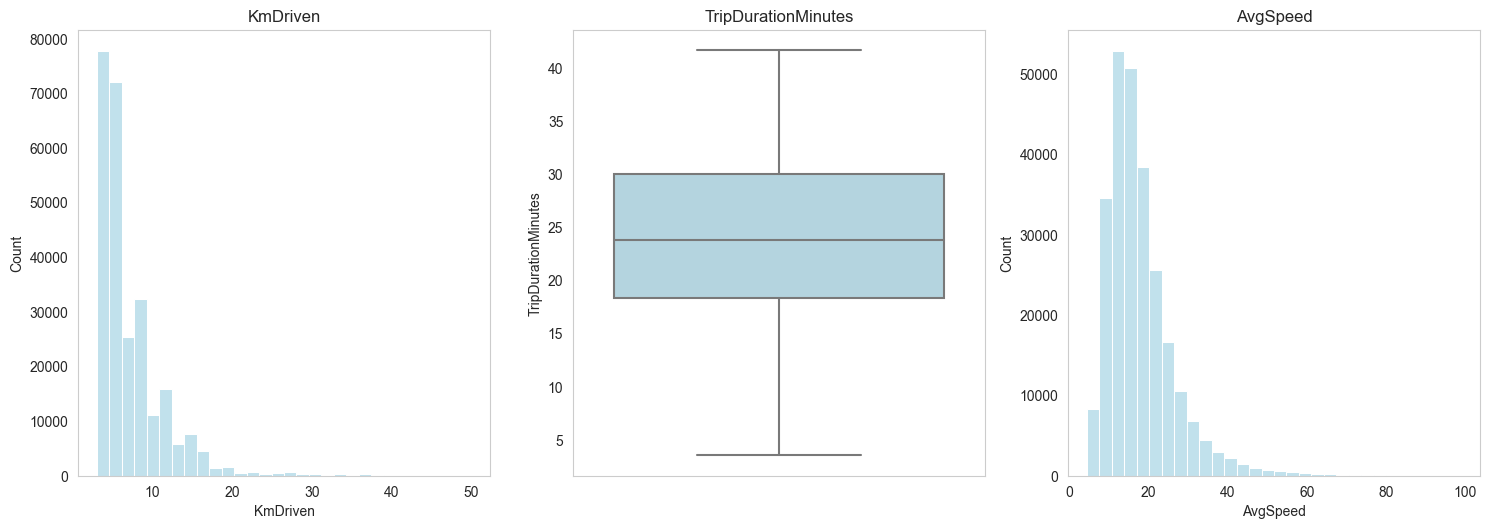

In [463]:
columns = ['KmDriven', 'TripDurationMinutes', 'AvgSpeed']

# Set the figure size
plt.figure(figsize=(15, 10))

# Create subplots for histograms
for i, column in enumerate(columns):
    plt.subplot(2, 3, i+1)
    if column == 'TripDurationMinutes':
        sns.boxplot(data=sn_processing[(sn_processing['KmDriven']>=3)&(sn_processing['TripDurationMinutes']<sn_processing['TripDurationMinutes'].quantile(0.85))], y=column, color='lightblue')
    else:
        sns.histplot(data=sn_processing[(sn_processing['KmDriven']>=3)&(sn_processing['TripDurationMinutes']<sn_processing['TripDurationMinutes'].quantile(0.85))], x=column, bins=30,color='lightblue')
    # sns.color_palette('rocket_r')
    sns.set_style('whitegrid')
    plt.grid(False)
    plt.title(column)
plt.tight_layout()

# Show the plot
plt.show()


In [464]:
# Display average daily demand per hour
sn_processing['Date'] = sn_processing['StartTime'].dt.date
days = sn_processing.groupby(['Date','StartHour']).agg({'TripID':'count'}).reset_index()
dfplot = days.groupby('StartHour').agg({'TripID':'mean'},).reset_index().rename(columns={'TripID':'AvgDemand'})

In [465]:
r = dfplot['AvgDemand'].tolist()
theta = np.arange(0,360,15)
width = [15]*24

ticktexts = [str(i)+":00" if i % 6 == 0 else '' for i in np.arange(24)]

fig = go.Figure(go.Barpolar(
    r=r,
    theta=[i-7.5 for i in theta],
    width=width,
    marker_color=dfplot['AvgDemand'],
    marker_colorscale=custom_blue_scale,
    marker_line_color="white",
    marker_line_width=2,
    opacity=0.9
))

fig.update_layout(
    template=None,
    polar=dict(
        hole=0.4,
        bgcolor='rgb(223, 223,223)',
        radialaxis=dict(
            showticklabels=False,
            ticks='',
            linewidth=2,
            linecolor='white',
            showgrid=False,
        ),
        angularaxis=dict(
            tickvals=[i for i in theta],
            ticktext=ticktexts,
            showline=True,
            direction='clockwise',
            period=24,
            linecolor='white',
            gridcolor='white',
            showticklabels=True,
            ticks=''
        )
    )
)

fig.show()

In [466]:
agg_trips_km = sn_processing[(sn_processing['KmDriven']>=3)&(sn_processing['KmDriven']<40)]\
    .groupby('Date')[['TripID','KmDriven']].agg({'TripID':'count','KmDriven':'sum'}).reset_index()
agg_trips_km['Weekday'] = pd.to_datetime(agg_trips_km['Date']).dt.day_name()
daily_trip_km = agg_trips_km.groupby('Weekday').agg({'TripID':'mean','KmDriven':'mean'}).reset_index()
daily_trip_km['KmDriven'] = np.round(daily_trip_km['KmDriven']/daily_trip_km['TripID'],decimals=2)
daily_trip_km['TripID'] = np.round(daily_trip_km['TripID'],decimals=0).astype(int)
daily_trip_km.rename(columns={'TripID':'AvgDemand','KmDriven':'AvgDistance'},inplace=True)

orderlist = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig = px.bar(daily_trip_km, x='Weekday', y='AvgDemand',category_orders={'Weekday':orderlist},color='AvgDistance',
             color_continuous_scale=custom_blue_scale,
             labels={'AvgDistance': 'Km', 'AvgDemand': 'Number of trips'})

fig.update_layout(width=700,height=600, template=None, font=dict(family='Aptos',size=20))
fig.update_traces()
fig.update_yaxes(showgrid=False)
fig.update_xaxes(
    ticktext=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
    tickvals=[0, 1, 2, 3, 4, 5, 6], showgrid=False, title=None
)

fig.show()

In [467]:
# Perform the Pearson correlation test
monday = sn_processing[sn_processing['Weekday'] == 'Monday']['KmDriven']
sunday = sn_processing[sn_processing['Weekday'] == 'Sunday']['KmDriven']

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(monday, sunday, alternative='two-sided')

# Print the test results
print("Mann-Whitney U statistic:", statistic)
print("p-value:", p_value)


Mann-Whitney U statistic: 1030388996.0
p-value: 3.077489241116825e-05


In [468]:
sn_processing.groupby('AgeBracket')['UserID'].unique().apply(len).reset_index().rename(columns={'UserID':'Number of users'})

,AgeBracket,Number of users
0,18-29,10635
1,30-39,7758
2,40-49,4411
3,50-59,1886
4,60-90,443


In [469]:
# Extract the average speed for each age group
age_group_18_29 = sn_processing[sn_processing['AgeBracket'] == '18-29']['AvgSpeed']
age_group_30_39 = sn_processing[sn_processing['AgeBracket'] == '30-39']['AvgSpeed']
age_group_40_49 = sn_processing[sn_processing['AgeBracket'] == '40-49']['AvgSpeed']
age_group_50_59 = sn_processing[sn_processing['AgeBracket'] == '50-59']['AvgSpeed']
age_group_60_90 = sn_processing[sn_processing['AgeBracket'] == '60-90']['AvgSpeed']

# Perform one-way ANOVA test
f_statistic, p_value = f_oneway(age_group_18_29, age_group_30_39, age_group_40_49, age_group_50_59, age_group_60_90)

# Check the p-value
if p_value < 0.05:
    print("There is a statistically significant difference between the mean of average speed across age groups.")
else:
    print("There is no statistically significant difference between the mean of average speed across age groups.")


There is a statistically significant difference between the mean of average speed across age groups.


In [470]:
# Extract the 'Age' and 'AvgSpeed' columns from the DataFrame
age = sn_processing['Age']
avg_speed = sn_processing['AvgSpeed']

# Perform the Pearson correlation test
correlation, p_value = pearsonr(age, avg_speed)

# Print the correlation coefficient and p-value
print("Pearson correlation coefficient:", correlation)
print("p-value:", p_value)


Pearson correlation coefficient: -0.06216925649391497
p-value: 5.858472794464589e-299


### 2.1 GREEN MOBILITY: Data cleaning and processing

In [471]:
describecols = ['Age','KmDriven','TripDurationHours','TripDurationMinutes','AvgSpeed']
gm_processing.replace([np.inf, -np.inf], np.nan, inplace=True)
gm_processing[describecols].describe().T.style.format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
Age,110444.00,31.43,11.88,0.00,22.00,28.00,38.00,93.00
KmDriven,169126.00,14.23,16.22,0.54,3.19,6.98,19.05,102.00
TripDurationHours,110444.00,0.84,8.41,-0.00,0.25,0.42,0.65,2210.30
TripDurationMinutes,110444.00,50.40,504.73,-0.03,15.20,25.32,39.27,132617.73
AvgSpeed,110434.00,14.32,31.65,-4870.51,6.66,11.88,18.47,7076.26


In [472]:
gm_processing = gm_processing[gm_processing['Age']>0]
gm_processing = gm_processing.dropna(subset=['Age', 'KmDriven', 'TripDurationMinutes', 'AvgSpeed'])
gm_processing = gm_processing[gm_processing['AvgSpeed']<100]
gm_processing = gm_processing[gm_processing['KmDriven']>3]
gm_processing[describecols].describe().T.style.format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
Age,70520.00,31.86,11.68,18.00,22.00,28.00,39.00,93.00
KmDriven,70520.00,7.15,3.76,3.00,4.35,6.12,8.78,38.20
TripDurationHours,70520.00,0.80,9.60,0.04,0.33,0.48,0.68,2210.30
TripDurationMinutes,70520.00,47.73,575.75,2.58,19.65,28.77,41.00,132617.73
AvgSpeed,70520.00,15.51,8.71,0.00,9.43,14.05,19.96,88.99


In [473]:
# Drop missing values in the dataset gm_processing
gm_processing = gm_processing.dropna(subset=['Age', 'KmDriven', 'TripDurationMinutes', 'AvgSpeed'])
gm_processing = gm_processing[(gm_processing['KmDriven']>0)]
gm_processing = gm_processing[gm_processing['TripDurationMinutes']>3]
gm_processing = gm_processing[gm_processing['Age']>0]
gm_processing = gm_processing[gm_processing['AvgSpeed']<100]
gm_processing = gm_processing[gm_processing['KmDriven']>3]
gm_processing = gm_processing[gm_processing['TripDurationMinutes']<gm_processing['TripDurationMinutes'].quantile(0.90)]

In [474]:
gm_processing['KmDriven']=np.round(gm_processing['KmDriven']).astype(int)
gm_processing[describecols].describe().T.style.format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
Age,63463.00,31.76,11.63,18.00,22.00,28.00,38.00,93.00
KmDriven,63463.00,6.98,3.64,3.00,4.00,6.00,9.00,33.00
TripDurationHours,63463.00,0.47,0.20,0.05,0.31,0.45,0.61,0.96
TripDurationMinutes,63463.00,28.23,11.94,3.13,18.80,26.85,36.63,57.88
AvgSpeed,63463.00,16.57,8.39,3.12,10.53,14.95,20.74,88.99


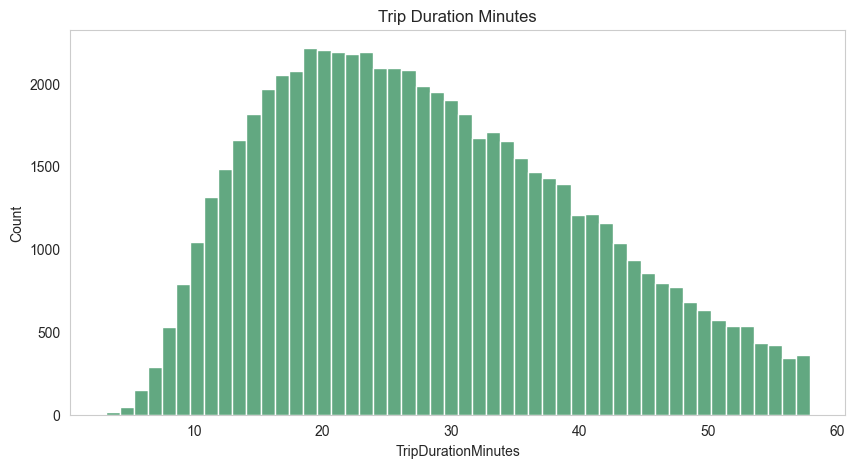

In [475]:
# plot gm_processing['TripDurationHours'] histogram using seaborn
plt.figure(figsize=(10, 5))
sns.histplot(data=gm_processing, x='TripDurationMinutes', bins=50, color='seagreen')
sns.set_style('whitegrid')
plt.grid(False)
plt.title('Trip Duration Minutes')
plt.show()

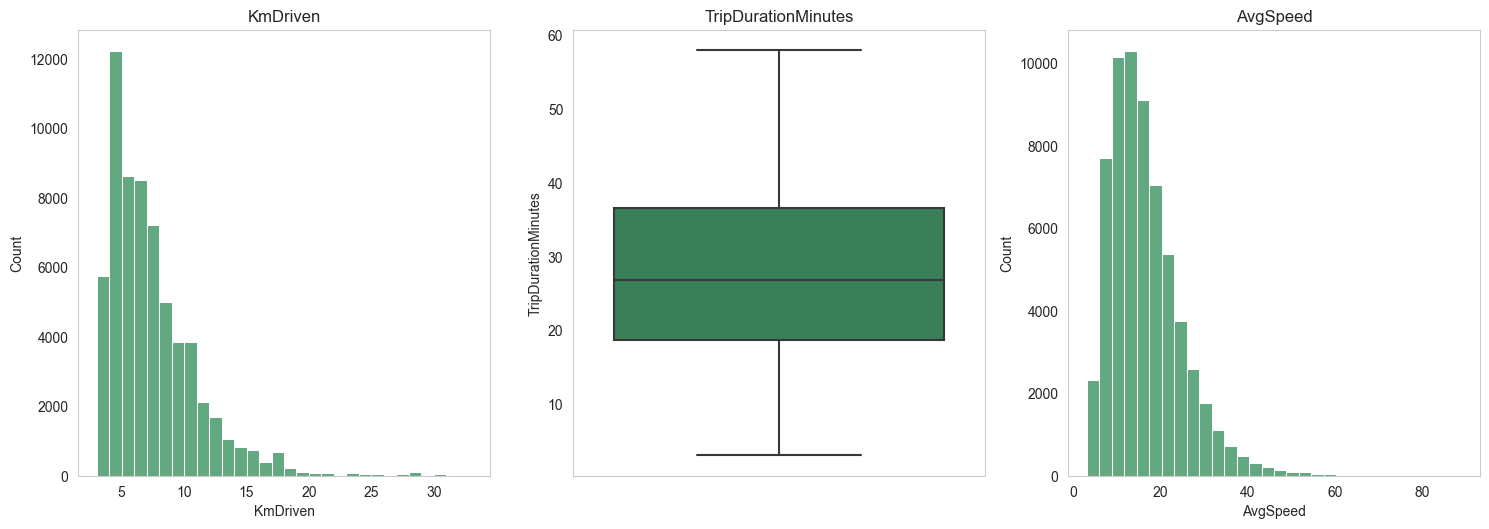

In [476]:
columns = ['KmDriven', 'TripDurationMinutes', 'AvgSpeed']

# Set the figure size
plt.figure(figsize=(15, 10))

# Create subplots for histograms
for i, column in enumerate(columns):
    plt.subplot(2, 3, i+1)
    if column == 'TripDurationMinutes':
        sns.boxplot(data=gm_processing, y=column, color='seagreen')
    else:
        sns.histplot(data=gm_processing, x=column, bins=30,color='seagreen')
    # sns.boxplot(data=gm_processing[(gm_processing['KmDriven']>=3)&(gm_processing['AvgSpeed']<100)&(gm_processing['AvgSpeed']>5)], y=column, color='seagreen')
    # sns.color_palette('rocket_r')
    sns.set_style('whitegrid')
    plt.grid(False)
    plt.title(column)
plt.tight_layout()

# Show the plot
plt.show()


In [477]:
gm_processing.groupby('AgeBracket')['UserID'].unique().apply(len).reset_index().rename(columns={'UserID':'Number of users'})

,AgeBracket,Number of users
0,18-29,3339
1,30-39,1754
2,40-49,1434
3,50-59,816
4,60-90,223


In [478]:
# Initialize ShareNow and GreenMobility datasets
gm_original = pd.read_csv('../data/raw/GM_preparedData.csv')
# sn_original = pd.read_excel('../data/raw/DriveNow/DTU - data til case_LTMZones1.xlsx')

#   ----------------------------------------------------------------------------
#   GREENMOBILITY PART
#   ----------------------------------------------------------------------------

# Rename GreenMobility columns
dict_gm_renamecols = {'id':'TripID',
                        'vehicleId':'CarID',
                        'id2':'UserID',
                        'startPositionLat':'LatitudeStart',
                        'startPositionLng':'LongitudeStart',
                        'endPositionLat':'LatitudeEnd',
                        'endPositionLng':'LongitudeEnd',
                        'tripStart':'StartTime',
                        'tripEnd':'EndTime',
                        'birthday':'Age',
                        'key':'Gender',
                        'DriveLength':'KmDriven'
                      }

# List the columns to be kept for GreenMobility
gmkeepcols_list = ['TripID','CarID',
                   'UserID','LatitudeStart',
                   'LongitudeStart','LatitudeEnd',
                   'LongitudeEnd','StartTime',
                   'EndTime','Age','Gender','KmDriven',
                   'FromZoneID','ToZoneID']

gm_test = gm_original.rename(columns=dict_gm_renamecols)
gm_test = gm_test[gmkeepcols_list]

# Convert StartTime and EndTime to Datetime
gm_test['StartTime'] = pd.to_datetime(gm_test['StartTime'], errors='coerce', format='%d%b%y:%H:%M:%S')
gm_test['EndTime'] = pd.to_datetime(gm_test['EndTime'], errors='coerce' , format='%d%b%y:%H:%M:%S')

gm_test['TripDurationHours'] = (gm_test['EndTime'] - gm_test['StartTime']).dt.total_seconds()/3600
gm_test['TripDurationMinutes'] = gm_test['TripDurationHours']*60  #   trip duration in min
gm_test['AvgSpeed'] = gm_test['KmDriven']/gm_test['TripDurationHours'] #   avg speed
gm_test['Month'] = gm_test['StartTime'].dt.strftime("%B").astype('category')  #   month
gm_test['Weekday'] = gm_test['StartTime'].dt.day_name().astype('category')    #   day of the week
gm_test['StartHour'] = gm_test['StartTime'].dt.hour.astype('category')    #   hour of the day
gm_test['Date'] = gm_test['StartTime'].dt.date  #   date
gm_test['AgeBracket'] = gm_test['Age'].apply(get_bracket)   #   age bracket

In [479]:
gm_test.groupby('AgeBracket')['UserID'].unique().apply(len).reset_index().rename(columns={'UserID':'Number of users'})

,AgeBracket,Number of users
0,18-29,3777
1,30-39,1998
2,40-49,1654
3,50-59,943
4,60-90,277


In [480]:
n_steps = 5  # Define the number of steps you want in your color scale
custom_green_scale = generate_custom_green_scale(n_steps, dark_start=True)

agg_df = gm_processing.groupby('AgeBracket')['KmDriven'].agg(['mean','count']).reset_index()
fig = px.bar(agg_df, x='AgeBracket', y='count', color='mean',
             color_continuous_scale=custom_green_scale,
             labels={'mean': 'Km', 'count': 'Number of trips', 'AgeBracket':'Age group'})

fig.update_layout(width=500,height=600, template=None, font=dict(family='Aptos',size=18))
fig.update_traces()
# fig.update_yaxes(showgrid=False)
fig.update_xaxes(showgrid=False)
fig.show()


In [481]:
spped = gm_processing.groupby('AgeBracket')['AvgSpeed'].agg(['mean','count']).reset_index()
fig = px.bar(spped, x='AgeBracket', y='count', color='mean',
             color_continuous_scale=custom_green_scale,
             labels={'mean': 'Km/h', 'count': 'Number of trips', 'AgeBracket':'Age group'})

fig.update_layout(width=500,height=600, template=None, font=dict(family='Aptos',size=18))
fig.update_traces()
# fig.update_yaxes(showgrid=False)
fig.update_xaxes(showgrid=False)
fig.show()

In [488]:
custom_green_scale = generate_custom_green_scale(7, dark_start=True)

agg_trips_km = gm_processing\
    .groupby('Date')[['TripID','KmDriven']].agg({'TripID':'count','KmDriven':'sum'}).reset_index()
agg_trips_km['Weekday'] = pd.to_datetime(agg_trips_km['Date']).dt.day_name()
daily_trip_km = agg_trips_km.groupby('Weekday').agg({'TripID':'mean','KmDriven':'mean'}).reset_index()
daily_trip_km['KmDriven'] = np.round(daily_trip_km['KmDriven']/daily_trip_km['TripID'],decimals=2)
daily_trip_km['TripID'] = np.round(daily_trip_km['TripID'],decimals=0).astype(int)
daily_trip_km.rename(columns={'TripID':'AvgDemand','KmDriven':'AvgDistance'},inplace=True)

orderlist = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig = px.bar(daily_trip_km, x='Weekday', y='AvgDemand',category_orders={'Weekday':orderlist},color='AvgDistance',
             color_continuous_scale=custom_green_scale,
             labels={'AvgDistance': 'Km', 'AvgDemand': 'Number of trips'})

fig.update_layout(width=700,height=600, template=None, font=dict(family='Aptos',size=20))
fig.update_traces()
fig.update_yaxes(showgrid=False)
fig.update_xaxes(
    ticktext=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
    tickvals=[0, 1, 2, 3, 4, 5, 6], showgrid=False, title=None
)

fig.show()

In [500]:
# sn_processing['Date'] = sn_processing['StartTime'].dt.date
days = gm_processing.groupby(['Date','StartHour']).agg({'TripID':'count'}).reset_index()
dfplot = days.groupby('StartHour').agg({'TripID':'mean'},).reset_index().rename(columns={'TripID':'AvgDemand'})

custom_green_scale = generate_custom_green_scale(24, dark_start=True)

r = dfplot['AvgDemand'].tolist()
theta = np.arange(0,360,15)
width = [15]*24

ticktexts = [str(i)+":00" if i % 6 == 0 else '' for i in np.arange(24)]

fig = go.Figure(go.Barpolar(
    r=r,
    theta=[i-7.5 for i in theta],
    width=width,
    marker_color=dfplot['AvgDemand'],
    marker_colorscale=custom_green_scale,
    marker_line_color="white",
    marker_line_width=2,
    opacity=0.9
))

fig.update_layout(
    template=None,
    polar=dict(
        hole=0.4,
        bgcolor='rgb(223, 223,223)',
        radialaxis=dict(
            showticklabels=False,
            ticks='',
            linewidth=2,
            linecolor='white',
            showgrid=False,
        ),
        angularaxis=dict(
            tickvals=[i for i in theta],
            ticktext=ticktexts,
            showline=True,
            direction='clockwise',
            period=24,
            linecolor='white',
            gridcolor='white',
            showticklabels=True,
            ticks=''
        )
    )
)

fig.show()

In [502]:
dfplot

,StartHour,AvgDemand
0,0.0,11.043478
1,1.0,6.891304
2,2.0,4.706522
3,3.0,3.826087
4,4.0,5.000000
5,5.0,10.032609
6,6.0,17.858696
7,7.0,37.043478
8,8.0,42.510870
9,9.0,32.184783


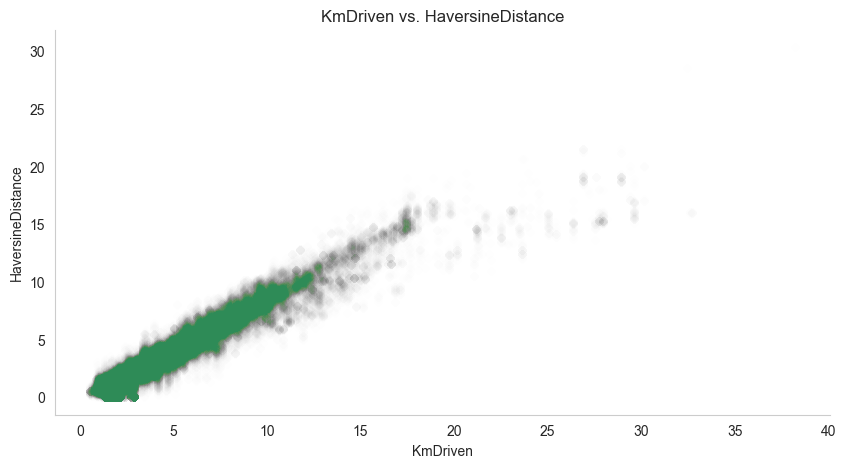

In [499]:
gm_test['HaversineDistance'] = hsd(gm_test['LatitudeStart'], gm_test['LongitudeStart'],gm_test['LatitudeEnd'], gm_test['LongitudeEnd'])

# # scatterplot of gm_processing['KmDriven'] vs. gm_processing['HaveDistance']

plt.figure(figsize=(10, 5))
sns.scatterplot(data=gm_test, x='KmDriven', y='HaversineDistance', color='seagreen', alpha=0.005)
sns.set_style('whitegrid')
sns.despine()
plt.grid(False)
plt.title('KmDriven vs. HaversineDistance')
plt.show()

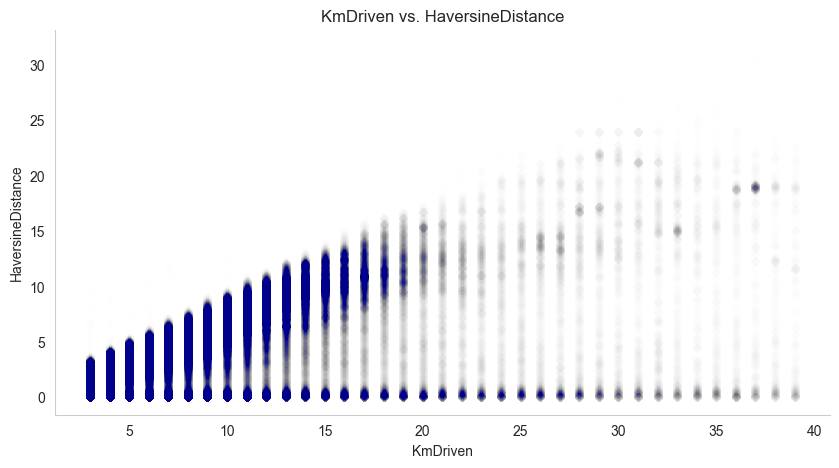

In [498]:
# # scatterplot of gm_processing['KmDriven'] vs. gm_processing['HaveDistance']

plt.figure(figsize=(10, 5))
sns.scatterplot(data=sn_processing[(sn_processing['KmDriven']>=3)&(sn_processing['KmDriven']<40)], x='KmDriven', y='HaversineDistance', color='darkblue', alpha=0.005)
sns.set_style('whitegrid')
sns.despine()
plt.grid(False)
plt.title('KmDriven vs. HaversineDistance')
plt.show()

In [503]:
gm_original.describe().T.style.format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
FromZoneID,169130.00,146087.19,49799.75,102110.00,102550.00,147210.00,165040.00,999100.00
ToZoneID,169130.00,146049.73,49764.17,102110.00,102540.00,147210.00,165040.00,912140.00
DriveLength,169126.00,14.23,16.22,0.54,3.19,6.98,19.05,102.00
FreeTime,169126.00,13.49,11.40,1.27,5.92,8.76,17.89,74.20
CongTime,169126.00,0.00,0.01,0.00,0.00,0.00,0.00,0.19
CarGenCost,169126.00,51.54,46.79,0.00,18.35,35.41,73.81,324.25
NoOfChange,169126.00,0.54,0.68,0.00,0.00,0.10,1.00,4.44
WaitT,169126.00,1.17,2.08,0.00,0.00,0.06,1.51,41.36
ZoneWaitT,169126.00,5.71,4.14,0.36,2.76,4.39,7.01,55.11
ZoneConT,169126.00,15.11,7.19,3.00,10.09,14.83,19.50,51.49


### 1.3 Data cleaning and processing: Donkey Republic